# Diseño Óptimo de Red Eléctrica Jerarquizada con D-Wave
## Máster de Computación Cuántica - Universidad Nebrija

**Autores:** Francesco Orizzonte, Ana Ruiz, David Lobato, Víctor Sánchez, Daniel Rivero  
**Fecha:** 19 de diciembre, 2025

---

## 1. Introducción y Contexto del Problema

El objetivo de este proyecto es modelar y resolver un problema de optimización combinatoria para el diseño de una red de distribución eléctrica. Buscamos conectar una fuente de **Alta Tensión (HV)** con consumidores finales minimizando el **Coste Total de Propiedad (TCO)**, que incluye CAPEX (inversión en infraestructura) y OPEX (cableado).

### Definición de Conjuntos y Variables

En el problema se definen varios conjuntos de variables **binarias**. Las hay de dos tipos: construcción de **centros** y construcción de **conexiones**. Las variables activas (1) indican que sí se construye el elemento al que están asociado, mientras que si están desactivadas (0) indican que no se construye.

* **$S$**: Fuente de Alta Tensión (HV).
* **$J$**: Candidatos a Centros de Media Tensión (MV)           --> Variable $y_j$.
* **$K$**: Candidatos a Centros de Baja Tensión (LV)            --> Variable $z_k$.
* **$I$**: Clientes Industriales                                --> Variable de conexión $w_{i,j}$ (conecta $i$ a $j$).
* **$D$**: Clientes Domésticos                                  --> Variable de conexión $v_{d,k}$ (conecta $d$ a $k$).
* **$U$**: Conexiones entre transformador $k$ y subestación $j$ --> Variable de conexión **$u_{k,j}$** (conecta $k$ a $j$).

El conjunto de variables será: $\{y_j, z_k, w_{i,j}, u_{k,j}, v_{d,k}\}$

Para resolver este problema utilizando tecnologías cuánticas, utilizaremos el SDK **Ocean** de D-Wave.

---

## 2. Formulación del problema

Este cuaderno implementa la formulación matemática para el diseño óptimo de una red eléctrica jerarquizada utilizando **Quantum Annealing**.

### Modelo General

El problema se define mediante un hamiltoniano (función de coste) que incluye una parte objetivo y las restricciones impuestas a las soluciones. El problema consiste en encontrar la solución que proporciona el **mínimo** de energía (coste) posible:
$$H_{total} = H_{obj} + H_{restricciones}$$

### A. Función Objetivo ($H_{obj}$)
Minimiza el CAPEX (inversión en centros) y el OPEX (coste de cableado).

$$
H_{obj} = \sum_{j \in J} C_{MV}y_j + \sum_{k \in K} C_{LV}z_k 
+ \sum_{j \in J} D_{S,j}C_{cable\_S\_MV}y_j
+ \sum_{i \in I}\sum_{j \in J} (D_{i,j}C_{cable\_MV})w_{i,j} 
+ \sum_{d \in D}\sum_{k \in K} (D_{d,k}C_{cable\_LV})v_{d,k} 
+ \sum_{k \in K}\sum_{j \in J} (D_{k,j}C_{cable\_MV})u_{k,j}
$$

Los dos primeros términos hacen referencia al coste de construcción de centros de transformación, mientras que el resto de términos recogen el coste del establecimiento de las conexiones.

Comentario: si no tenemos en cuenta nada más, el mínimo de energía de esta función se correspondería a no construir nada con un coste asociado de 0€. Así que a esta función hay que añadirle unos términos de restricciones que recojan los requerimientos de la infraestructura.

### B. Restricciones y Penalizaciones

Las restricciones aseguran la viabilidad física y lógica de la red. Se incorporan al objetivo mediante términos de penalización $P_n$ (donde $P_n$ es una constante suficientemente grande) de manera que fuercen a que la solución cumpla dichas restricciones.

En este problema vamos a imponer tres restricciones:
* **Cobertura de demanda única:** todos los clientes deben tener exactamente 1 suministrador de energía
* **Coherencia de existencia:** las conexiones solo se pueden hacer si existen los dos nodos
* **Coherencia de flujo:** si construimos LV, debe tener conexión a MV

Cada una de estas restricciones es de diferente naturaleza como veremos a continuación.

#### B.1. Cobertura de Demanda (Unicidad)
Cada consumidor final debe estar conectado a **exactamente un** punto de suministro para garantizar el servicio y evitar duplicidades.

$$
H_{req} = P_1\sum_{i\in I}\left(\sum_{j\in J}w_{i,j}-1\right)^{2} + P_2\sum_{d\in D}\left(\sum_{k\in K}v_{d,k}-1\right)^{2}
$$

#### B.2. Coherencia de Existencia ("Si conecto, debe existir")
Garantiza que no se establezcan conexiones hacia instalaciones inexistentes. Si un cable se activa, la instalación de destino debe estar construida ($y_j=1$ o $z_k=1$). Utilizamos la penalización de producto cruzado $P_n(x_{ab} - x_{ab}y_b)$.

$$
\begin{aligned}
H_{coh\_exist} = & P_3\sum_{i\in I}\sum_{j\in J}(w_{i,j}-w_{i,j}y_{j}) \quad (\text{Industrial a MV}) \\
& + P_4\sum_{k\in K}\sum_{j\in J}(u_{k,j}-u_{k,j}y_{j}) \quad (\text{Centro LV a MV}) \\
& + P_5\sum_{d\in D}\sum_{k\in K}(v_{d,k}-v_{d,k}z_{k}) \quad (\text{Doméstico a LV})
\end{aligned}
$$

#### B.3. Coherencia de Flujo ("Si construyo LV, debe tener alimentación")
Esta restricción modela la lógica de la cadena de suministro intermedia. Un Centro LV ($z_k$) debe tener una alimentación "aguas arriba" si y solo si está construido.

* Si $z_k=1$ (construido), debe conectarse a exactamente un Centro MV ($\sum u_{k,j} = 1$).
* Si $z_k=0$ (no construido), no puede tener conexiones ($\sum u_{k,j} = 0$).

$$
H_{flow} = P_6\sum_{k\in K}\left(\sum_{j\in J}u_{k,j}-z_{k}\right)^{2}
$$

---

## 3. Código de implementación

In [2]:
# Importación de librerías
import pandas as pd
import numpy as np
import dimod
import neal
import itertools

print("Librerías cargadas correctamente.")

ModuleNotFoundError: No module named 'pandas'

### 3.1. Lectura y procesamiento del archivo de datos

El código interactúa con un archivo externo que contiene todos los datos del sistema. A continuación, haremos una función para leer el archivo `datos.csv` que se encuentra en el directorio local. 

El archivo tiene una estructura mixta:
1.  **Metadatos (Filas 0-3):** Cantidad de variables por tipo (J, K, Ind, Dom).
2.  **Costes de cable (Fila 4-6):** Coste de los cables por unidad de longitud.
3.  **Encabezado y Datos (Fila 7 en adelante):** Coordenadas de los nodos y los precios de inversión inicial en el caso de los transformadores.

Separamos la lectura para capturar tanto la configuración del escenario como la ubicación de los nodos.

In [ ]:
def cargar_datos_escenario(filepath):

    # 1. LEER METADATOS (Contadores y Costes)
    # Leemos las primeras 7 filas para extraer configuración y precios
    meta_df = pd.read_csv(filepath, header=None, nrows=7)
    
    config = {}
    for _ , row in meta_df.iterrows():
        # Limpieza de strings (quitar comillas y espacios)
        key = row[0].replace('"', '').strip()
        value = row[1]
        config[key] = int(value)
    
    #EXTRAER VARIABLES SEPARADAS
    # Asignamos los costes de cable a variables individuales
    coste_cable_hv = config["Coste_Cable_HV"]
    coste_cable_mv = config["Coste_Cable_MV"]
    coste_cable_lv = config["Coste_Cable_LV"]

    # 2. LEER DATOS DE LOS NODOS
    # Saltamos las 7 filas de metadatos para leer el DataFrame principal
    df_nodos = pd.read_csv(filepath, skiprows=7)

    # Aseguramos que la columna nombre sea string limpio
    df_nodos['Nombre'] = df_nodos['Nombre'].astype(str).str.strip()

    
    return config, df_nodos, coste_cable_hv, coste_cable_mv, coste_cable_lv

# Nombre del archivo
nombre_archivo = 'datos1.csv' 

try:

    (config, df_nodos,C_HV, C_MV, C_LV) = cargar_datos_escenario(nombre_archivo)
    
    print("\nVariables de Cable (Separadas)")
    print(f"Variable C_HV (Fuente->MV): {C_HV}")   
    print(f"Variable C_MV (MV->Ind/LV): {C_MV}")   
    print(f"Variable C_LV (LV->Dom):    {C_LV}")  

    print("\nDataFrame de Nodos")
    display(df_nodos)

except FileNotFoundError:
    print(f"Error: No se encontró el archivo en {nombre_archivo}")
except KeyError as e:
    print(f"Error: No se encontró la clave {e} en el archivo CSV. Revisa los nombres.")


Variables de Cable (Separadas)
Variable C_HV (Fuente->MV): 500
Variable C_MV (MV->Ind/LV): 500
Variable C_LV (LV->Dom):    500

DataFrame de Nodos


,Nombre,Coord_X,Coord_Y,Cost
0,S,10,50,0
1,J1,70,80,15500
2,J2,50,50,17000
3,J3,75,20,11000
4,K1,30,70,7700
5,K2,70,25,10000
6,K3,80,80,6700
7,Ind1,85,85,0
8,Ind2,90,75,0
9,Ind3,75,15,0


### 3.2. Cálculo de la matriz de distancias

Una de las hipótesis de nuestro problema es que lo haremos en un espacio euclídeo 2D, por lo que nuestras distancias serán lineas rectas de un punto a otro. Para codificar estás distancias se decidió hacerlo con una matriz triangular que muestre solo las distancias relevantes. Para esto se ha aplicando un **filtro de conectividad** basado en la jerarquía de la red. Solo calculamos distancias para conexiones válidas:

* **S $\leftrightarrow$ J**
* **J $\leftrightarrow$ K**
* **J $\leftrightarrow$ Ind**
* **K $\leftrightarrow$ Dom**

El resto de conexiones (ej. K-K, S-Dom) se establecen a 0. Además, aseguramos que la matriz sea **triangular superior** para evitar duplicidades en el grafo.

In [ ]:
def calcular_matriz_triangular(df):
    n = len(df)
    dist_matrix = np.zeros((n, n))
    
    names = df['Nombre'].values
    coords = df[['Coord_X', 'Coord_Y']].values
    
    # Identificamos el tipo de nodo por su prefijo
    def get_type(name):
        if name.startswith('S'): return 'S'
        if name.startswith('J'): return 'J'
        if name.startswith('K'): return 'K'
        if name.startswith('Ind'): return 'Ind'
        if name.startswith('Dom'): return 'Dom'
        return 'Unknown'

 
    for i in range(n):
        for j in range(n):
            
            if i < j:
                type_a = get_type(names[i])
                type_b = get_type(names[j])
                
                # Definimos pares válidos (conjuntos para ignorar el orden)
                pair = {type_a, type_b}
                
                es_valido = False
                if pair == {'S', 'J'}: es_valido = True
                elif pair == {'J', 'K'}: es_valido = True
                elif pair == {'J', 'Ind'}: es_valido = True
                elif pair == {'K', 'Dom'}: es_valido = True
                
                if es_valido:
                    # Distancia Euclídea
                    d = np.linalg.norm(coords[i] - coords[j])
                    dist_matrix[i, j] = d
                else:
                    dist_matrix[i, j] = 0.0

    return dist_matrix

    
matriz_distancias = calcular_matriz_triangular(df_nodos)
df_resultado = pd.DataFrame(
    matriz_distancias,
    index=df_nodos['Nombre'],
    columns=df_nodos['Nombre']
)

print("Matriz de Distancias (Formato Triangular Superior con Filtro de Conectividad):")
df_resultado

Matriz de Distancias (Formato Triangular Superior con Filtro de Conectividad):


Nombre,S,J1,J2,J3,K1,K2,K3,Ind1,Ind2,Ind3,Ind4,Dom1,Dom2,Dom3,Dom4
Nombre,,,,,,,,,,,,,,,
S,0.0,67.082039,40.0,71.589105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
J1,0.0,0.000000,0.0,0.000000,41.231056,55.000000,10.000000,15.811388,20.615528,65.192024,57.008771,0.000000,0.000000,0.000000,0.000000
J2,0.0,0.000000,0.0,0.000000,28.284271,32.015621,42.426407,49.497475,47.169906,43.011626,43.011626,0.000000,0.000000,0.000000,0.000000
J3,0.0,0.000000,0.0,0.000000,67.268120,7.071068,60.207973,65.764732,57.008771,5.000000,11.180340,0.000000,0.000000,0.000000,0.000000
K1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.071068,7.071068,78.102497,81.394103
K2,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.268120,53.150729,20.615528,21.213203
K3,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.226805,47.434165,60.827625,70.178344
Ind1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ind2,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### 3.3. Desarrollo del problema usando dimod

Si desarrollamos las expresiones de las restricciones y agrupamos términos, obtenemos la expresión final para construir el **Binary Quadratic Model (BQM)**.

En el hamiltoniano objetivo solo aparecían términos lineales, pero al desarrollar las restricciones aparecen tanto términos lineales como cuadráticos. Los términos lineales se suman y aparecen en la diagonal de la matriz del problema, mientras que los términos cuadráticos aparecen fuera de la diagonal y modelan las interacciones entre las variables.

La expresión final queda:

$$
H_{total} = \sum_{j} \underbrace{[C_{MV} + D_{S,j}C_{S\_MV}]}_{\text{Lineal } y_j} y_j + \sum_{k} \underbrace{[C_{LV} + P_6]}_{\text{Lineal } z_k} z_k
$$

$$
+ \sum_{i}\sum_{j} \underbrace{[D_{i,j}C_{cable\_MV}+ (P_3-P_1)]}_{\text{Lineal } w_{i,j}} w_{i,j} + \sum_{d}\sum_{k} \underbrace{[D_{d,k}C_{cable\_LV}+ (P_5-P_2)]}_{\text{Lineal } v_{d,k}} v_{d,k}
$$

$$
+ \sum_{k}\sum_{j} \underbrace{[D_{k,j}C_{cable\_MV} + (P_4+P_6)]}_{\text{Lineal } u_{k,j}} u_{k,j}
$$

$$
\text{(Términos Cuadráticos / Interacciones)}
$$

$$
- P_3 \sum_{i}\sum_{j} w_{i,j}y_j - P_4 \sum_{k}\sum_{j} u_{k,j}y_j - P_5 \sum_{d}\sum_{k} v_{d,k}z_k - 2P_6 \sum_{k}\sum_{j} u_{k,j}z_k
$$

$$
+ 2P_1 \sum_{i}\sum_{p}\sum_{j > p} w_{i,p}w_{i,j} + 2P_2 \sum_{d}\sum_{m} \sum_{k > p} v_{d,p}v_{d,k} + 2P_6 \sum_{k}\sum_{p} \sum_{j > p} u_{k,p}u_{k,j}
$$

* Nota: Al final de cuaderno se incluye un anexo con comentarios adicionales sobre el desarrollo de las restricciones.

In [ ]:

# 1. CONFIGURACIÓN INICIAL

# Penalización P debe ser relativamente grande pero no tanto como para dominar sobre los costes reales.
# Si P es demasiado bajo, el sistema preferirá violar restricciones para minimizar costes.
# Elegimos P como 10 veces el coste máximo de inversión.
P = df_nodos['Cost'].max()*2

P1 = P
P2 = P
P3 = P
P4 = P
P5 = P
P6 = P

# Inicializamos el Modelo Binario Cuadrático (BQM) vacío
bqm = dimod.BinaryQuadraticModel(dimod.BINARY)

# Clasificamos los nodos usando el DataFrame de nodos (df_nodos)
# Asumimos que 'Nombre' es columna o índice. Aquí aseguramos que sea accesible.
if 'Nombre' in df_nodos.columns:
    nodos_idx = df_nodos.set_index('Nombre')
else:
    nodos_idx = df_nodos

# Listas de identificadores
J_nodos = [n for n in nodos_idx.index if n.startswith('J')]   # Media Tensión
K_nodos = [n for n in nodos_idx.index if n.startswith('K')]   # Baja Tensión
Ind_nodos = [n for n in nodos_idx.index if n.startswith('Ind')] # Clientes Industriales
Dom_nodos = [n for n in nodos_idx.index if n.startswith('Dom')] # Clientes Domésticos
Fuente = 'S'

print(f"Formulando problema para: {len(J_nodos)} Subestaciones, {len(K_nodos)} Transformadores.")




# 2. TÉRMINOS LINEALES (Bias lineales h_i) --> Diagonal de la Matriz Q

# A. Infraestructura Media Tensión (y_j)
# Coste = Inversión (Tabla) + Cable desde Fuente (C_HV * Distancia)
for j in J_nodos:
    coste_inversion = nodos_idx.loc[j, 'Cost']
    dist_S_j = df_resultado.loc[Fuente, j] # Leemos de tu matriz triangular
    
    # Coeficiente final para y_j
    bias = coste_inversion + (dist_S_j * C_HV)
    bqm.add_variable(f"y_{j}", bias)

# B. Infraestructura Baja Tensión (z_k)
# Coste = Inversión (Tabla) + Penalización P6 (viene de restricción de flujo)
for k in K_nodos:
    coste_inversion = nodos_idx.loc[k, 'Cost']
    
    bias = coste_inversion + (P6)
    bqm.add_variable(f"z_{k}", bias)

# C. Conexiones Industrial -> MV (w_ij)
# Coste = Cable MV * Distancia
# Nota: Los términos lineales +P3 (coherencia) y -P1 (unicidad)
for i in Ind_nodos:
    for j in J_nodos:
        dist = df_resultado.loc[j, i] # Buscamos en la matriz (simétrica en lógica)
        if dist == 0: dist = df_resultado.loc[i, j] # Por si está en el triángulo opuesto
            
        bias = dist * C_MV + (P3-P1)
        bqm.add_variable(f"w_{i}_{j}", bias)

# D. Conexiones LV -> MV (u_kj)
# Coste = Cable MV * Distancia + P4 (coherencia) + P6 (flujo)
for k in K_nodos:
    for j in J_nodos:
        dist = df_resultado.loc[j, k]
        if dist == 0: dist = df_resultado.loc[k, j]
        
        bias = (dist * C_MV) + (P4+P6)
        bqm.add_variable(f"u_{k}_{j}", bias)

# E. Conexiones Doméstico -> LV (v_dk)
# Coste = Cable LV * Distancia + P5 (coherencia) - P2 (unicidad)
for d in Dom_nodos:
    for k in K_nodos:
        dist = df_resultado.loc[k, d]
        if dist == 0: dist = df_resultado.loc[d, k]
        
        bias = (dist * C_LV) + (P5-P2)
        bqm.add_variable(f"v_{d}_{k}", bias)

# 3. TÉRMINOS CUADRÁTICOS (Interacciones J_ij) - Fuera de la Diagonal

# A. Restricciones de Unicidad (Solo un padre)
# Penalizamos si se activan dos conexiones para el mismo hijo (+2Pn)


# Industriales (w_ij1 * w_ij2)

for i in Ind_nodos:
    for j1, j2 in itertools.combinations(J_nodos, 2):
        bqm.add_interaction(f"w_{i}_{j1}", f"w_{i}_{j2}",  2*P1)

# Domésticos (v_dk1 * v_dk2)
for d in Dom_nodos:
    for k1, k2 in itertools.combinations(K_nodos, 2):
        bqm.add_interaction(f"v_{d}_{k1}", f"v_{d}_{k2}",  2*P2)

# Transformadores LV (u_kj1 * u_kj2)
for k in K_nodos:
    for j1, j2 in itertools.combinations(J_nodos, 2):
        bqm.add_interaction(f"u_{k}_{j1}", f"u_{k}_{j2}",  2*P6)
        

# B. Restricciones de Coherencia de Existencia
# "Si me conecto a X, X debe estar construido". Penalización -Pn (favorece tener ambos a 1)
# Matemáticamente es Pn(x - xy), el término lineal +Pn ya se sumó arriba, aquí va el -Pn*xy.

# Industrial -> MV (w_ij * y_j)
for i in Ind_nodos:
    for j in J_nodos:
        bqm.add_interaction(f"w_{i}_{j}", f"y_{j}", -P3)

# Doméstico -> LV (v_dk * z_k)
for d in Dom_nodos:
    for k in K_nodos:
        bqm.add_interaction(f"v_{d}_{k}", f"z_{k}", -P5)

# LV -> MV (u_kj * y_j)
for k in K_nodos:
    for j in J_nodos:
        bqm.add_interaction(f"u_{k}_{j}", f"y_{j}", -P4)

# C. Restricción de Flujo (Cadena de Suministro)
# Un transformador K solo debe conectarse si está construido (z_k).
# Interacción especial: -2P6 * u_kj * z_k

for k in K_nodos:
    for j in J_nodos:
        bqm.add_interaction(f"u_{k}_{j}", f"z_{k}", - 2*P6)

# 4. INSPECCIÓN DEL MODELO

print("\nModelo QUBO Generado")
print(f"Variables (Qubits lógicos): {bqm.num_variables}")
print(f"Interacciones: {bqm.num_interactions}")

Formulando problema para: 3 Subestaciones, 3 Transformadores.

Modelo QUBO Generado
Variables (Qubits lógicos): 39
Interacciones: 75


### 3.4 Resolución del problema

Se usará el simulador de ocean neal.

In [ ]:
# EJECUCIÓN DEL SOLVER (Simulated Annealing - Configuración Robusta)

# Creamos el sampler
sampler = neal.SimulatedAnnealingSampler()

# Ejecutamos el muestreo con MÁS profundidad
# num_sweeps=10000: Es la "paciencia" del algoritmo. Al subirlo (por defecto es bajo),
# le damos tiempo para escapar de soluciones caras y encontrar la más barata.
num_reads = 2000
sampleset = sampler.sample(
    bqm, 
    num_reads=num_reads,          # Hacemos 2000 intentos distintos
    num_sweeps=10000,        # Aumentamos la búsqueda en cada intento (CLAVE para estabilidad)
    num_sweeps_per_beta=100  # Pasos por nivel de temperatura
)

# FILTRADO DE SOLUCIONES VÁLIDAS

# Filtramos para quedarnos solo con las que cumplen las reglas (Energía < P)
# Si las penalizaciones son altas, las soluciones válidas tendrán energía negativa.
# E = Costes_Reales - P1*len(Ind_nodos) - P2*len(Dom_nodos)
umbral_validez = -P
valid_samples = sampleset.filter(lambda s: s.energy <= umbral_validez)

if len(valid_samples) > 0:
    # Si hay soluciones válidas, cogemos la mejor de ellas
    best_sample = valid_samples.first.sample
    best_energy = valid_samples.first.energy
    print(f"✅ Se encontraron {len(valid_samples)}/{num_reads} soluciones válidas.")
else:
    # Si no hay ninguna válida (raro con P alto), cogemos la mejor que haya y avisamos
    print("⚠️ ALERTA: El solver no encontró soluciones perfectas. Se muestra la mejor aproximación.")
    best_sample = sampleset.first.sample
    best_energy = sampleset.first.energy

print(f"\nSimulación Completada")
print(f"Mejor energía encontrada: {round(best_energy,2)}")
print(f"Mejor Presupuesto: {round(best_energy+P1*len(Ind_nodos)+P2* len(Dom_nodos),2)}")

✅ Se encontraron 2000/2000 soluciones válidas.

Simulación Completada
Mejor energía encontrada: -80024.3
Mejor Presupuesto: 191975.7


### 3.5. Verificación del problema y coste

In [ ]:
#DECODIFICACIÓN Y REPORTE DE RESULTADOS

def interpretar_resultados(sample):
    """
    Traduce el diccionario de variables binarias (0 y 1) a texto legible.
    """
    print("\n" + "="*40)
    print("       DISEÑO ÓPTIMO DE LA RED       ")
    print("="*40)
    
    # Listas para agrupar la salida
    infra_mv = []
    infra_lv = []
    conn_ind = []
    conn_dom = []
    conn_inter = []
    
    
    # Iteramos sobre las variables activas (valor = 1)
    for variable, valor in sample.items():
        if valor == 1:
            # Desglosamos el nombre (ej: "w_Ind1_J2" -> tipo="w", origen="Ind1", destino="J2")
            partes = variable.split('_')
            tipo = partes[0]
            
            if tipo == 'y': # Infraestructura MV
                nodo = partes[1]
                infra_mv.append(f"Subestación {nodo} (Construida)")
                
            elif tipo == 'z': # Infraestructura LV
                nodo = partes[1]
                infra_lv.append(f"Transformador {nodo} (Construido)")
                
            elif tipo == 'w': # Conexión Ind -> MV
                origen, destino = partes[1], partes[2]
                conn_ind.append(f"Industria {origen}  -->  Subestación {destino}")
                
            elif tipo == 'v': # Conexión Dom -> LV
                origen, destino = partes[1], partes[2]
                conn_dom.append(f"Doméstico {origen}  -->  Transformador {destino}")
                
            elif tipo == 'u': # Conexión LV -> MV
                origen, destino = partes[1], partes[2]
                conn_inter.append(f"Transformador {origen}  -->  Subestación {destino}")

    # --- IMPRIMIR REPORTE ---
    
    print(f"\n[1] INFRAESTRUCTURA MEDIA TENSIÓN (MV):")
    if not infra_mv: print("  Ninguna construida (¡Alerta!)")
    for item in sorted(infra_mv): print(f"  ✅ {item}")

    print(f"\n[2] INFRAESTRUCTURA BAJA TENSIÓN (LV):")
    if not infra_lv: print("  Ninguna construida")
    for item in sorted(infra_lv): print(f"  ✅ {item}")
    
    print(f"\n[3] CONEXIONES INDUSTRIALES (Ind -> MV):")
    for item in sorted(conn_ind): print(f"  🔌 {item}")

    print(f"\n[4] ALIMENTACIÓN INTERMEDIA (LV -> MV):")
    for item in sorted(conn_inter): print(f"  ⚡ {item}")
    
    print(f"\n[5] CONEXIONES DOMÉSTICAS (Dom -> LV):")
    for item in sorted(conn_dom): print(f"  🏠 {item}")

    # Verificación rápida de reglas
    print("\n" + "-"*40)
    print("VERIFICACIÓN DE REGLAS:")
    
    # Regla: Todos los clientes conectados
    total_ind = len([k for k in sample if k.startswith('w') and sample[k] == 1])
    total_dom = len([k for k in sample if k.startswith('v') and sample[k] == 1])
    
    print(f"Clientes Industriales conectados: {total_ind}/{len(Ind_nodos)}")
    print(f"Clientes Domésticos conectados:   {total_dom}/{len(Dom_nodos)}")
    
    if total_ind != len(Ind_nodos) or total_dom != len(Dom_nodos):
        print("❌ ADVERTENCIA: Algunos clientes no tienen servicio. Revisa la penalización P.")
    else:
        print("✅ COBERTURA COMPLETA: Todos los usuarios tienen servicio.")


def calcular_presupuesto_real(sample, df_nodos, df_distancias, C_HV, C_MV, C_LV):
    """
    Calcula el coste monetario real a partir del coste de infraestructura.
    """
    print("\n" + "="*50)
    print("       PRESUPUESTO DETALLADO DEL PROYECTO (€)       ")
    print("="*50)
    
    total_inversion = 0
    total_cableado = 0
    
    # Listas para desglose
    items_infra = []
    items_cable = []

    # Iteramos sobre las variables activas (que valen 1)
    for key, val in sample.items():
        if val == 1:
            partes = key.split('_')
            tipo = partes[0]
            
            # --- INFRAESTRUCTURA (CAPEX) ---
            if tipo == 'y': # Subestación MV
                nodo = partes[1]
                coste = df_nodos.loc[nodo, 'Cost']
                items_infra.append(f"Subestación {nodo}: {coste:,.2f} €")
                total_inversion += coste
                
                # En tu modelo, activar 'y' también implica el cable HV desde la fuente
                dist = df_distancias.loc['S', nodo]
                coste_hv = dist * C_HV
                items_cable.append(f"Cable HV (Fuente -> {nodo}): {dist:.2f}m * {C_HV}€ = {coste_hv:,.2f} €")
                total_cableado += coste_hv
                
            elif tipo == 'z': # Transformador LV
                nodo = partes[1]
                coste = df_nodos.loc[nodo, 'Cost']
                items_infra.append(f"Transformador {nodo}: {coste:,.2f} €")
                total_inversion += coste

            # --- CABLEADO (OPEX/Conexión) ---
            elif tipo == 'w': # Ind -> MV
                origen, destino = partes[1], partes[2]
                dist = df_distancias.loc[destino, origen]
                coste = dist * C_MV
                items_cable.append(f"Cable MV ({origen}->{destino}): {dist:.2f}m * {C_MV}€ = {coste:,.2f} €")
                total_cableado += coste
                
            elif tipo == 'v': # Dom -> LV
                origen, destino = partes[1], partes[2]
                dist = df_distancias.loc[destino, origen]
                coste = dist * C_LV
                items_cable.append(f"Cable LV ({origen}->{destino}): {dist:.2f}m * {C_LV}€ = {coste:,.2f} €")
                total_cableado += coste
                
            elif tipo == 'u': # LV -> MV
                origen, destino = partes[1], partes[2]
                dist = df_distancias.loc[destino, origen]
                coste = dist * C_MV
                items_cable.append(f"Cable MV ({origen}->{destino}): {dist:.2f}m * {C_MV}€ = {coste:,.2f} €")
                total_cableado += coste

    # --- IMPRIMIR RESULTADOS ---
    print("\n🏗️  INVERSIÓN EN INFRAESTRUCTURA (Centros):")
    for item in sorted(items_infra): print(f"  - {item}")
    print(f"  >> Subtotal Infraestructura: {total_inversion:,.2f} €")
    
    print("\n⚡  COSTE DE CABLEADO (Transporte):")
    for item in sorted(items_cable): print(f"  - {item}")
    print(f"  >> Subtotal Cableado: {total_cableado:,.2f} €")
    
    print("-" * 50)
    print(f"💰  COSTE TOTAL DEL PROYECTO: {total_inversion + total_cableado:,.2f} €")
    print("-" * 50)

    return total_inversion + total_cableado

try:
    # Calculamos el coste real de la infraestructura
    total_calculado = calcular_presupuesto_real(best_sample, nodos_idx,df_resultado,C_HV, C_MV, C_LV)

except NameError as e:
    print(f"Error: Falta alguna variable definida ({e}). Asegúrate de haber corrido las celdas anteriores.")
except KeyError as e:
    print(f"Error de índice: {e}. Revisa que df_resultado tenga los nombres como índice.")


interpretar_resultados(best_sample)

# Verificación final: Comparar coste calculado vs coste del solver
total_solver = best_energy + P1*len(Ind_nodos) + P2* len(Dom_nodos)
if round(total_calculado,2) == round(total_solver,2):
    print(f"\nPresupuesto calculado: {round(total_calculado,2)}€\nPresupuesto solver: {round(total_solver,2)}€")
    print("✅ Todas las restricciones es han cumplido.")
    # Si no se cumplieran, entonces los valores no coincidirían.
else:
    print(f"❌ No se cumplen todas las restricciones. Coste calculado: {total_calculado}€, Coste solver: {total_solver}€")



       PRESUPUESTO DETALLADO DEL PROYECTO (€)       

🏗️  INVERSIÓN EN INFRAESTRUCTURA (Centros):
  - Subestación J1: 15,500.00 €
  - Subestación J3: 11,000.00 €
  - Transformador K1: 7,700.00 €
  - Transformador K2: 10,000.00 €
  >> Subtotal Infraestructura: 44,200.00 €

⚡  COSTE DE CABLEADO (Transporte):
  - Cable HV (Fuente -> J1): 67.08m * 500€ = 33,541.02 €
  - Cable HV (Fuente -> J3): 71.59m * 500€ = 35,794.55 €
  - Cable LV (Dom1->K1): 7.07m * 500€ = 3,535.53 €
  - Cable LV (Dom2->K1): 7.07m * 500€ = 3,535.53 €
  - Cable LV (Dom3->K2): 20.62m * 500€ = 10,307.76 €
  - Cable LV (Dom4->K2): 21.21m * 500€ = 10,606.60 €
  - Cable MV (Ind1->J1): 15.81m * 500€ = 7,905.69 €
  - Cable MV (Ind2->J1): 20.62m * 500€ = 10,307.76 €
  - Cable MV (Ind3->J3): 5.00m * 500€ = 2,500.00 €
  - Cable MV (Ind4->J3): 11.18m * 500€ = 5,590.17 €
  - Cable MV (K1->J1): 41.23m * 500€ = 20,615.53 €
  - Cable MV (K2->J3): 7.07m * 500€ = 3,535.53 €
  >> Subtotal Cableado: 147,775.70 €
------------------------

## 6 Gráfico del problema

Esta parte es realizada de forma pedagógica para poder ver de una mejor manera el problema y sus soluciones. El problema fue planteado desde el inicio con las coordenadas con la idea de poder visualizarlo.


       MAPA GRÁFICO DE LA SOLUCIÓN       


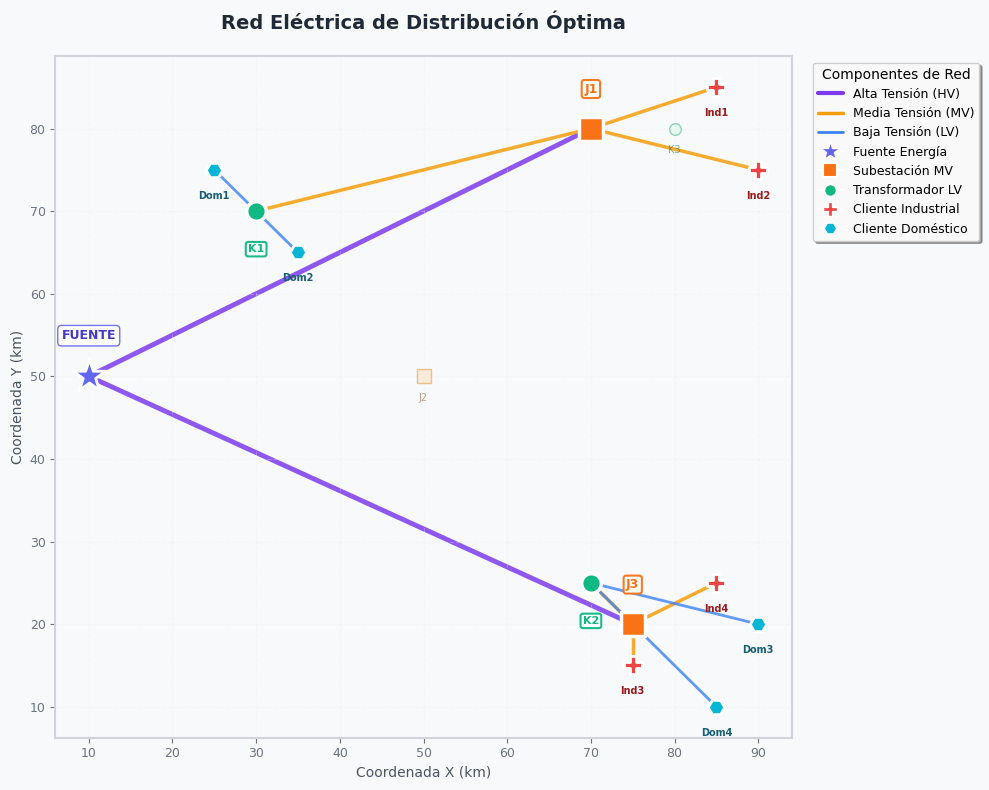

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


def pintar_solucion(sample, df_nodos):
    """
    Visualiza la red óptima resultante con diseño profesional y atractivo.
    Optimizado para mejor experiencia de usuario.
    """
    
    print("\n" + "="*50)
    print("       MAPA GRÁFICO DE LA SOLUCIÓN       ")
    print("="*50)
    
    # PREPARACIÓN DE DATOS
    coords = {row['Nombre']: (row['Coord_X'], row['Coord_Y']) for idx, row in df_nodos.iterrows()}
    
    nodes_mv_active = []
    nodes_lv_active = []
    lines_hv = []
    lines_mv = []
    lines_lv = []

    for variable, valor in sample.items():
        if valor == 1:
            partes = variable.split('_')
            tipo = partes[0]
            
            if tipo == 'y':
                nodo = partes[1]
                nodes_mv_active.append(nodo)
                lines_hv.append((coords['S'], coords[nodo]))
                
            elif tipo == 'z':
                nodo = partes[1]
                nodes_lv_active.append(nodo)
            
            elif tipo == 'w':
                origen, destino = partes[1], partes[2]
                lines_mv.append((coords[origen], coords[destino]))
                
            elif tipo == 'u':
                origen, destino = partes[1], partes[2]
                lines_mv.append((coords[origen], coords[destino]))
                
            elif tipo == 'v':
                origen, destino = partes[1], partes[2]
                lines_lv.append((coords[origen], coords[destino]))

    COLORS = {
        'bg': '#F8F9FA',
        'grid': '#E9ECEF',
        'hv_line': '#7C3AED',
        'mv_line': '#F59E0B',
        'lv_line': '#3B82F6',
        'source': '#6366F1',
        'mv_active': '#F97316',
        'lv_active': '#10B981',
        'industrial': '#EF4444',
        'domestic': '#06B6D4',
        'candidate_mv': '#FED7AA',
        'candidate_lv': '#D1FAE5',
        'client_ind': '#FEE2E2',
        'client_dom': '#CFFAFE'
    }
    
    fig, ax = plt.subplots(figsize=(10, 8), facecolor=COLORS['bg'])
    ax.set_facecolor(COLORS['bg'])
    
    # HV (Púrpura)
    for p1, p2 in lines_hv:
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
                color=COLORS['hv_line'], linewidth=3.5, 
                alpha=0.85, solid_capstyle='round', zorder=1)
        
    # MV (Naranja)
    for p1, p2 in lines_mv:
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
                color=COLORS['mv_line'], linewidth=2.5, 
                alpha=0.85, solid_capstyle='round', zorder=2)
        
    # LV (Azul)
    for p1, p2 in lines_lv:
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
                color=COLORS['lv_line'], linewidth=2, 
                alpha=0.8, solid_capstyle='round', zorder=3)


    # PINTAR NODOS BASE
    
    for idx, row in df_nodos.iterrows():
        nombre = row['Nombre']
        x, y = row['Coord_X'], row['Coord_Y']
        
        if nombre == 'S':
            continue
        elif nombre.startswith('J') and nombre not in nodes_mv_active:
            ax.scatter(x, y, c=COLORS['candidate_mv'], marker='s', 
                      s=100, edgecolors='#D97706', linewidths=1, 
                      alpha=0.4, zorder=4)
            ax.text(x, y-3, nombre, fontsize=7, color='#92400E', 
                   ha='center', alpha=0.5)
                   
        elif nombre.startswith('K') and nombre not in nodes_lv_active:
            ax.scatter(x, y, c=COLORS['candidate_lv'], marker='o', 
                      s=70, edgecolors='#059669', linewidths=1, 
                      alpha=0.4, zorder=4)
            ax.text(x, y-3, nombre, fontsize=7, color='#065F46', 
                   ha='center', alpha=0.5)


    # PINTAR NODOS ACTIVOS
    
    # Fuente S (Estrella grande)
    sx, sy = coords['S']
    ax.scatter(sx, sy, c=COLORS['source'], marker='*', s=600, 
              edgecolors='white', linewidths=2, zorder=10)
    ax.text(sx, sy+4.5, "FUENTE", fontsize=9, fontweight='bold', 
           ha='center', color='#4338CA', 
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                    edgecolor=COLORS['source'], alpha=0.9))
    
    # Subestaciones MV Construidas
    for mv in nodes_mv_active:
        x, y = coords[mv]
        ax.scatter(x, y, c=COLORS['mv_active'], marker='s', s=280, 
                  edgecolors='white', linewidths=2.5, zorder=9)
        
        ax.text(x, y+4, mv, fontsize=9, fontweight='bold', 
               ha='center', va='bottom', color=COLORS['mv_active'],
               bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                        edgecolor=COLORS['mv_active'], linewidth=1.5, alpha=0.95))
        
    # Transformadores LV Construidos
    for lv in nodes_lv_active:
        x, y = coords[lv]
        ax.scatter(x, y, c=COLORS['lv_active'], marker='o', s=200, 
                  edgecolors='white', linewidths=2.5, zorder=9)
        
        ax.text(x, y-4, lv, fontsize=8, fontweight='bold', 
               ha='center', va='top', color=COLORS['lv_active'],
               bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                        edgecolor=COLORS['lv_active'], linewidth=1.5, alpha=0.95))
        
    # Clientes Industriales
    industrial_nodes = [n for n in coords if n.startswith('Ind')]
    for ind in industrial_nodes:
        x, y = coords[ind]
        ax.scatter(x, y, c=COLORS['industrial'], marker='P', s=180, 
                  edgecolors='white', linewidths=2, zorder=8)
        ax.text(x, y-3.5, ind, fontsize=7, ha='center', 
               color='#991B1B', fontweight='600')


    # Clientes Domésticos
    domestic_nodes = [n for n in coords if n.startswith('Dom')]
    for dom in domestic_nodes:
        x, y = coords[dom]
        ax.scatter(x, y, c=COLORS['domestic'], marker='H', s=140, 
                  edgecolors='white', linewidths=2, zorder=8)
        ax.text(x, y-3.5, dom, fontsize=7, ha='center', 
               color='#155E75', fontweight='600')


    # LEYENDA PERSONALIZADA
    
    legend_elements = [
        Line2D([0], [0], color=COLORS['hv_line'], linewidth=3, 
               label='Alta Tensión (HV)', solid_capstyle='round'),
        Line2D([0], [0], color=COLORS['mv_line'], linewidth=2.5, 
               label='Media Tensión (MV)', solid_capstyle='round'),
        Line2D([0], [0], color=COLORS['lv_line'], linewidth=2, 
               label='Baja Tensión (LV)', solid_capstyle='round'),
        Line2D([0], [0], marker='*', color='w', 
               markerfacecolor=COLORS['source'], markersize=15, 
               label='Fuente Energía'),
        Line2D([0], [0], marker='s', color='w', 
               markerfacecolor=COLORS['mv_active'], markersize=10, 
               label='Subestación MV', markeredgewidth=1.5, markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='w', 
               markerfacecolor=COLORS['lv_active'], markersize=9, 
               label='Transformador LV', markeredgewidth=1.5, markeredgecolor='white'),
        Line2D([0], [0], marker='P', color='w', 
               markerfacecolor=COLORS['industrial'], markersize=10, 
               label='Cliente Industrial'),
        Line2D([0], [0], marker='H', color='w', 
               markerfacecolor=COLORS['domestic'], markersize=9, 
               label='Cliente Doméstico')
    ]
    
    legend = ax.legend(handles=legend_elements, loc='upper left', 
                      bbox_to_anchor=(1.02, 1), frameon=True, 
                      fancybox=True, shadow=True, fontsize=9,
                      title='Componentes de Red', title_fontsize=10)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.95)
    
    # ESTILO FINAL
    
    ax.set_title('Red Eléctrica de Distribución Óptima', 
                fontsize=14, fontweight='bold', pad=20, 
                color='#1F2937')
    ax.set_xlabel('Coordenada X (km)', fontsize=10, color='#4B5563')
    ax.set_ylabel('Coordenada Y (km)', fontsize=10, color='#4B5563')
    
    ax.grid(True, linestyle='--', alpha=0.3, color=COLORS['grid'], linewidth=0.8)
    ax.tick_params(colors='#6B7280', labelsize=9)
    
    for spine in ax.spines.values():
        spine.set_edgecolor('#D1D5DB')
        spine.set_linewidth(1.5)
    
    plt.tight_layout()
    plt.show()


# Llamada para usar la función:
pintar_solucion(best_sample, df_nodos)

## ANEXO I. Desarrollo de las restricciones y forma de la matriz QUBO

### A. Objetivo
En este apartado vamos a desarrollar las expresiones de los hamiltonianos objetivo y de restricciones y a ver cómo se traducen a términos de la matriz que representa al problema.

### B. Introducción
Las variables del problema se recogen en el conjunto $x = \{y_j, z_k, w_{i,j}, u_{k,j}, v_{d,k}\}$. Por tanto, el vector de variables tendrá $N$ componentes con $N= N_j + N_k + N_iN_j + N_kN_j + N_dN_k$, donde:
* $N_j$ número de centros MV
* $N_k$ número de centros LV
* $N_i$ número de clientes industriales
* $N_d$ número de clientes domésticos

Y las matrices que representan la función objetivo y las restricciones serán de dimension $N$ x $N$.

En primer lugar, hay que notar que las variables del problema son de diferente naturaleza. Por ejemplo, las $\{y_j\}$ representan la construcción de un centro de media tensión (MV), las $\{z_k\}$ la construcción de un centro de baja tensión (LV) y las $\{u_{j,k}\}$ la construcción de cableado entre el centro $MV_j$ y el centro $LV_k$. Y las restricciones normalmente aplican a cada grupo de variables por separado o entre ellos, pero rara vez a todos a la vez. Por tanto, **la matriz del problema se podrá definir a bloques**, donde seguiremos el convenio siguiente:

$$
Q = \begin{pmatrix}
\boxed{y_j} &  &  &  &  \\[2ex]
 & \boxed{z_k} &  &  &  \\[2ex]
 &  & \boxed{w_{i,j}} &  &  \\[2ex]
 &  &  & \boxed{u_{k,j}} &  \\[2ex]
 &  &  &  & \boxed{v_{d,k}}
\end{pmatrix}
$$

En cada uno de los bloques marcados, incluiremos los términos independientes y cruzados de cada **conjunto de variables**. Fuera de esta diagonal de bloques, irán los términos cruzados **entre conjuntos de variables**.

En general, buscamos expresar el problema de variables binarias $\{x\}$ de la forma:

$$
H(x) = x^T Q x + A
$$

Donde $x^T$ es el vector de variables traspuesto, $A$ es una variable independiente, y $Q$ es una matriz que recoge la información del problema (relación entre variables).

En nuestro caso, tenemos una función objetivo y tres restricciones. Dividiremos esta expresión como:

$$
\begin{aligned}
& H(x) = x^T Q x + A \\[1ex]
& = x^T (Q_{obj}+Q_{req}+Q_{coh}+Q_{flw}) x + A \\[1ex]
& = x^T Q_{obj} x + x^T Q_{req} x + x^T Q_{coh} x + x^T Q_{flw} x + A
\end{aligned}
$$

En los siguientes apartados calculamos estas matrices y el término independiente de nuestro problema.

### C. Matriz objetivo

A partir del hamiltoniano objetivo, vemos que que todos los términos son lineales en las variables del problema. Esto se traduce en que la matriz objetivo será diagonal.

$$
\begin{aligned}
H_{obj} =
&   \sum_{j \in J} (C_{MV} + D_{S,j} \cdot C_{cable\_S\_MV}) y_j         \\
& + \sum_{k \in K} C_{LV} z_k                                            \\
& + \sum_{i \in I} \sum_{j \in J} (D_{i,j} \cdot C_{cable\_MV}) w_{i,j}  \\
& + \sum_{k \in K} \sum_{j \in J} (D_{k,j} \cdot C_{cable\_MV}) u_{k,j}  \\
& + \sum_{d \in D} \sum_{k \in K} (D_{d,k} \cdot C_{cable\_LV}) v_{d,k}  \\
\end{aligned}
$$

Concretamente:

$$
{\tiny
\boxed{
Q_{obj} = 
\begin{pmatrix}
\boxed{\begin{matrix} C_{MV}+D_{S,j}C_{cable\_S\_MV} & 0  & \\ 0 & C_{MV}+D_{S,j}C_{cable\_S\_MV} &  \\  &  & \ddots \end{matrix}} &  &  &  &  \\
 & \boxed{\begin{matrix} C_{LV} & 0 &  \\ 0 & C_{LV}  & \\  &  &  \ddots \end{matrix}} &  &  &  \\
 &  & \boxed{\begin{matrix} D_{i,j}C_{cable\_MV} & 0 &  \\ 0 & D_{i,j}C_{cable\_MV}  & \\  &  &\ddots \end{matrix}} & &  \\
&  &  & \boxed{\begin{matrix} D_{k,j}C_{cable\_MV} & 0 &  \\ 0 & D_{k,j}C_{cable\_MV} &  \\  &  & \ddots \end{matrix}} & \\
 &  &  &  & \boxed{\begin{matrix} D_{d,k}C_{cable\_LV} & 0 &  \\ 0 & D_{d,k}C_{cable\_LV} &  \\  &  & \ddots \end{matrix}}
\end{pmatrix}
}
}
$$

Y el hamiltoniano quedaría:

$$
H_{obj} = x^T Q_{obj} x
$$


### D. Matriz restricción (unicidad)

Cada cliente industrial $i$ o doméstico $d$ debe estar conectado exactamente a 1 proveedor $j$ o $k$ respectivamente:
 
$$H_{req} = P_1 \sum_{i \in I} \left( \sum_{j \in J} w_{i,j} - 1 \right)^2 + P_2 \sum_{d \in D} \left( \sum_{k \in K} v_{d,k} - 1 \right)^2$$

Esta restricción está formada por dos términos del mismo tipo. Desarrollando, por ejemplo, el primero de ellos:

$$
\begin{aligned}
& P_1 \sum_{i} \left( \sum_{j} w_{ij} - 1 \right)^2 = \\[1.5ex]
& P_1 \sum_{i} \left[ \left( \sum_{j} w_{ij} - 1 \right) \left( \sum_{j} w_{ij} - 1 \right) \right] = \\[1.5ex]
& P_1 \sum_{i} \left[ \left( \sum_{j} w_{ij} \right) \left( \sum_{j} w_{ij} \right) - 2 \sum_{j} w_{ij} + 1 \right] = \\[1.5ex]
& P_1 \sum_{i} \left( \sum_{p} \sum_{j} w_{ip} w_{ij} - 2 \sum_{j} w_{ij} + 1 \right) = \\[1.5ex]
& \left(\sum_{i} \sum_{p} \sum_{j} P_1 w_{ip} w_{ij}\right) - \sum_{i} \sum_{j} 2P_1 w_{ij} + \sum_{i} P_1 = \\[1.5ex]
& \left(\sum_{i} \sum_{j} P_1 w_{ij} + \sum_{i} \sum_{p} \sum_{j>p} 2P_1 w_{ip} w_{ij}\right) - \sum_{i} \sum_{j} 2P_1 w_{ij} + \sum_{i} P_1 = \\[1.5ex]
& \sum_{i} \sum_{j} -P_1 w_{ij} + \sum_{i} \sum_{p} \sum_{j>p} 2P_1 w_{ip} w_{ij} + P_1  N_i
\end{aligned}
$$

Donde finalmente hemos obtenido una expresión que nos da un término independiente ($P_1N_i$) y términos lineales y cruzados entre las variables $\{w_{ij}\}$. Notar que se ha dividido el sumatorio triple, en términos de la diagonal y términos de la matriz triangular superior (añadiendo un 2 extra para hacer 0 la matriz triangular inferior).

Repitiendo el proceso para el segundo término de la restricción obtenemos:

$$
\sum_{d} \sum_{k} -P_2 v_{dk} + \sum_{d} \sum_{p} \sum_{k>p} 2P_2 v_{dp} v_{dk} + P_2  N_d
$$

De manera que el hamiltoniano total de la restricción:

$$
\boxed{
H_{req} =
\left(\sum_{i} \sum_{j} -P_1 w_{ij} + \sum_{i} \sum_{p} \sum_{j>p} 2P_1 w_{ip} w_{ij}\right)
+
\left(\sum_{d} \sum_{k} -P_2 v_{dk} + \sum_{d} \sum_{p} \sum_{k>p} 2P_2 v_{dp} v_{dk}\right)
+
\left(P_1  N_i + P_2  N_d\right)}
$$

Y de forma matricial:

$$
H_{req} = x^T Q_{req} x + P_1N_i + P_2N_d
$$

Donde:

$$

Q_{req} =

\begin{pmatrix}
\boxed{0} &  &  &  &  \\

 & \boxed{0} &  &  &  \\

& & \boxed{\begin{matrix} -P_1 & 2P_1 & 2P_1 & \\ 0 & -P_1 & 2P_1 & \\ 0 & 0 & -P_1 & \\ & & &\ddots \end{matrix}} & &  \\

 & &  & \boxed{0} &  \\

 & &  &  & \boxed{\begin{matrix} -P_2 & 2P_2 & 2P_2 & \\ 0 & -P_2 & 2P_2 & \\ 0 & 0 & -P_2 & \\ & & & \ddots \end{matrix}}

\end{pmatrix}
$$






### E. Matriz restricción (coherencia de existencia)

Si conecto, debe existir:

$$
\begin{align*}
H_{coh} = & P_3 \sum_{i \in I} \sum_{j \in J} (w_{i,j} - w_{i,j}y_j) && \text{(Industrial a MV)} \\
& + P_4 \sum_{k \in K} \sum_{j \in J} (u_{k,j} - u_{k,j}y_j) && \text{(Centro LV a MV)} \\
& + P_5 \sum_{d \in D} \sum_{k \in K} (v_{d,k} - v_{d,k}z_k) && \text{(Doméstico a LV)}
\end{align*}
$$

En esta restricción contamos con tres términos iguales que relaciona pares de variables. Notar que no se elevan al cuadrado porque el valor de la expresión solo puede valer 0 (cuando se se cumple la restricción) o 1 (cuando no se cumple la restricción). Desarrollando el primero de los términos:

$$
\begin{aligned}
& P_3 \sum_{i} \sum_{j} (w_{ij} - w_{ij} y_j) = \\[1.5ex]
& \sum_{i} \sum_{j} P_3 w_{ij} - \sum_{i} \sum_{j} P_3 w_{ij} y_j
\end{aligned}
$$

Aparecen términos lineales en $\{w_{ij}\}$ y términos cruzados entre $\{w_{ij}\}$ y $\{y_{j}\}$.

Repitiendo para el segundo término obtenemos:

$$
\sum_{k} \sum_{j} P_4 u_{kj} - \sum_{k} \sum_{j} P_4 u_{kj} y_j
$$

De manera similar, el último término da:

$$
\sum_{d} \sum_{k} P_5 v_{dk} - \sum_{d} \sum_{k} P_5 v_{dk} z_k
$$

Por tanto, el hamiltoniano de esta restricción queda:

$$
\boxed{H_{coh} = \sum_{i} \sum_{j} P_3 w_{ij} 
+\sum_{k} \sum_{j} P_4 u_{kj} 
+\sum_{d} \sum_{k} P_5 v_{dk} 

- \sum_{i} \sum_{j} P_3 w_{ij} y_j
- \sum_{k} \sum_{j} P_4 u_{kj} y_j
- \sum_{d} \sum_{k} P_5 v_{dk} z_k
}
$$

De forma matricial:

$$
H_{coh} = x^T Q_{coh} x
$$


Donde:



$$
Q_{coh} = 
\begin{pmatrix}
\boxed{0} & \boxed{0} & \boxed{\begin{pmatrix}
-P_3 &        &      & -P_3   &          &      &   \\
     & \ddots &      &        &  \ddots  &      &   \\
     &        & -P_3 &        &          & -P_3 &  
\end{pmatrix}} & \boxed{\begin{pmatrix}
-P_4 &        &      & -P_4   &          &      &   \\
     & \ddots &      &        &  \ddots  &      &   \\
     &        & -P_4 &        &          & -P_4 &  
\end{pmatrix}} & \boxed{0} \\[6ex]
\boxed{0} & \boxed{0} & \boxed{0} & \boxed{0} & \boxed{\begin{pmatrix}
-P_5 &        &      & -P_5   &          &      &   \\
     & \ddots &      &        &  \ddots  &      &   \\
     &        & -P_5 &        &          & -P_5 &  
\end{pmatrix}} \\[6ex]
 \boxed{0}& \boxed{0} & \boxed{\begin{matrix} P_3 & & 0\\ & \ddots & \\0 & & P_3 \end{matrix}} & \boxed{0} & \boxed{0} \\[6ex]
\boxed{0} & \boxed{0} & \boxed{0} & \boxed{\begin{matrix} P_4 & & 0\\ & \ddots & \\0 & & P_4 \end{matrix}} & \boxed{0} \\[6ex]
 \boxed{0}& \boxed{0} & \boxed{0} & \boxed{0} & \boxed{\begin{matrix} P_5 & & 0\\ & \ddots & \\0 & & P_5 \end{matrix}}
\end{pmatrix} 
$$



### E. Matriz restricción (coherencia de flujo)

Si construyo LV ($z_k$), debe tener alimentación ($u_{kj}$)

$$
H_{flw} = P_6 \sum_{k} \left( \sum_{j} u_{k,j} - z_k \right)^2
$$

Esta restricción penaliza tanto si:
* $z_k = 0$ y $\sum_{j} u_{k,j} \neq 0$
* $z_k = 1$ y $\sum_{j} u_{k,j} = 0$

Desarrollando la expresión y usando el resultado del apartado C para escribir la expresión del cuadrado:

$$
\begin{aligned}
& H_{flow} = P_6 \sum_{k} \left( \sum_{p}\sum_{j} u_{k,p}u_{k,j} - 2z_k\sum_{j} u_{k,j} + z_k  \right) = \\[1.5ex]

& P_6 \left( \sum_{k}\sum_{p}\sum_{j} u_{k,p}u_{k,j} - 2P_6\sum_{k}\sum_{j} z_ku_{k,j} + \sum_{k}z_k  \right)

\end{aligned}

$$

Dividiendo el primer término en coeficientes de la diagonal y de la triangular superior, finalmente nos queda:
$$
\boxed{H_{flow} = \sum_{k} \sum_{j} P_6 u_{kj} + \sum_{k} \sum_{p} \sum_{j>p} 2P_6 u_{kp} u_{kj} +\sum_{k}\sum_{j}- 2P_6 z_ku_{k,j} + \sum_{k}P_6z_k}
$$



De esta restricción aparecen varios términos lineales y de interacción:
* Términos lineales en $u_{kj}$ y en $z_k$
* Terminos cuadráticos en $u_{k,j}$
* Términos cuadráticos entre $z_k$ y $u_{k,j}$


La matriz que representa esta restricción:

$$
\boxed{
Q_{flw} = 
\begin{pmatrix}
\boxed{0} & \boxed{0} & \boxed{0} & \boxed{0} & \boxed{0} \\
\boxed{0} & \boxed{\begin{matrix} P_6 & 0 & 0 & \\ 0 & P_6 & 0 & \\ 0 & 0 & P_6 & \\ & & &\ddots \end{matrix}} & \boxed{0} & \boxed{\begin{matrix}
 -2P_6 & -2P_6 & \cdots &  0   &  0    &         &\\
 0    &    0 & \cdots &-2P_6 & -2P_6 &         & \\
      &      & &      &       & \ddots  & \\

 \end{matrix}} & \boxed{0} \\
\boxed{0} & \boxed{0} & \boxed{0} & \boxed{0}& \boxed{0} \\
\boxed{0} & \boxed{0} & \boxed{0} & \boxed{\begin{matrix} P_6 & 2P_6 & 2P_6 & \\ 0 & P_6 & 2P_6 & \\ 0 & 0 & P_6 & \\ & & & \ddots \end{matrix}} & \boxed{0} \\
\boxed{0} & \boxed{0} & \boxed{0} & \boxed{0} & \boxed{0}
\end{pmatrix}
}
$$

### F. Conclusión

Usando los resultados de los apartados anteriores concluimos que:

$$
H(x) = x^T (Q_{obj} + Q_{req} + Q_{coh} + Q_{flw}) x + P_1N_i + P_2N_d
$$

En este problema destacamos las siguientes dificultades:
* Imposición de las restricciones adecuadas para obtener una infraestructura coherente.
* Trabajar con varios conjuntos de variables, algunas identificadas con dos subíndices.
* Ajustar los valores de penalización. Si es muy grande la solución no es estable. Si es baja se violan restricciones.

Una vez depurado el código, hemos sido capaces de probarlo con varias situaciones simples cuyo resultado conocíamos para comprobar la solución, y seguidamente probar situaciones más complejas jugando con los parámetros donde hemos llegado siempre a una situación aparentemente ideal (teniendo en cuenta distancias y precios de infraestructuras y cables).

Además también se ha generado un código para intrepretar los resultados cómodamente y una función para visualizar la infraestructura optimizada en un gráfico 2D.